Dataset Pequeno - https://www.kaggle.com/returnofsputnik/chihuahua-or-muffin

Dataset Grande - https://www.kaggle.com/ingrid2/moffinorchihuahua

In [1]:
#!pip install opencv-contrib-python

In [2]:
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2

def load_images_from_folder(folder, gray_scale=False, size=(32,32)):
    imgs = []
    for file in listdir(folder): 
        if isfile(join(folder,file)):
            img = cv2.imread(join(folder, file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if gray_scale else cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            imgs.append(cv2.resize(img, size))
        
    return np.array(imgs)

def load_data(base_path="data/small/", 
              chihuahuas_folder = "chihuahua", 
              muffins_folder = "muffin", 
              gray_scale=False,
             size=(32,32)):
    chihuahuas = load_images_from_folder(join(base_path, chihuahuas_folder), gray_scale, size)
    muffins = load_images_from_folder(join(base_path, muffins_folder), gray_scale, size)
    
    print(f"Carregadas {len(chihuahuas)} imagens de chihuahuas e {len(muffins)} de muffins")
    return {"chihuahuas": chihuahuas, "muffins": muffins}

size = (32,32)
data = load_data(base_path="data/big/",size=size)

Carregadas 279 imagens de chihuahuas e 273 de muffins


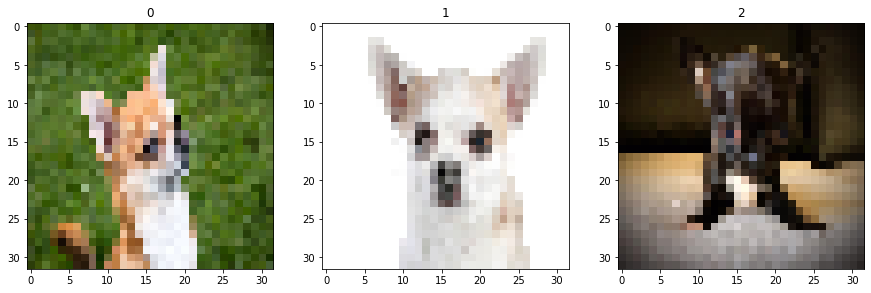

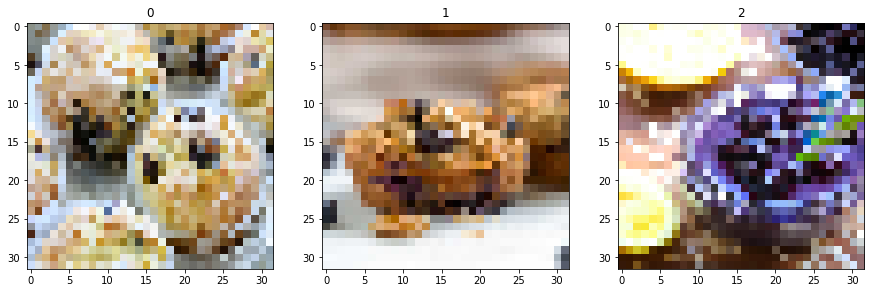

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from math import ceil
def plot_images(images, labels=[], figsize=(15,5), rows=2):
    n = len(images)
    if len(labels) == 0:
        labels = np.arange(n)
    
    columns = ceil(n / rows)
    
    plt.figure(figsize=figsize)
    for i,(img, label) in enumerate(zip(images, labels)):
        plt.subplot(rows, columns, i%columns + 1)
        plt.title(label)
        plt.imshow(img)
    plt.show()
        
plot_images(data["chihuahuas"][:3], rows=1)
plot_images(data["muffins"][:3], rows=1)

In [4]:
def images_to_2d(images):
    return images.reshape(images.shape[0], -1)

def process_data(data):
    X = np.vstack((images_to_2d(data["chihuahuas"]),images_to_2d(data["muffins"])))
    Y = np.array(["chihuahua" for _ in data["chihuahuas"]] + ["muffin" for _ in data["muffins"]])
    
    return X, Y


X,Y = process_data(data)
X.shape, Y.shape

((552, 3072), (552,))

In [5]:
class PPCA():
    
    def __init__(self, n_components = 2):
        self.L = n_components
        
    def log_likelihood(self, X, mean, W, M_inv, sigma, L):
        N,D = X.shape
        s = 0
        for x in X:
            z =  M_inv.dot(W.T).dot((x - mean))

            s += (D/2)*np.log(2*np.pi*sigma) + (L/2)*np.log(2*np.pi) + 0.5*np.trace(np.outer(z,z))
            s += (1/(2*sigma))*np.linalg.norm(x - mean)**2 - (1/sigma)*z.dot(W.T).dot(x-mean)
            s += 1/(2*sigma)*np.trace(np.outer(z,z).dot(W.T).dot(W))

        return -s

    def fit(self, X, W_0 = None, sigma_0=1, iter=10, debug=False):
        N,D = X.shape
        mean = np.mean(X, axis=0)
        
        L = self.L
        W = W_0.copy() if not W_0 is None else np.random.randn(D, L)
        sigma = sigma_0
        M_inv = None

        log_likelihoods = []

        for i in range(iter):
            M_inv = np.linalg.inv(W.T.dot(W) + sigma*np.eye(L))

            e_z = M_inv.dot(W.T).dot((X - mean).T)
            e_zz = sigma*M_inv + e_z.dot(e_z.T)

            W = ((X - mean).T.dot(e_z.T)).dot(np.linalg.inv(e_zz))

            s = 0
            for i,x in enumerate(X):
                e_zi = e_z[:,i]
                e_zzi = sigma*M_inv + np.outer(e_zi, e_zi) 
                s += np.linalg.norm(x-mean)**2 - 2*e_zi.T.dot(W.T).dot(x-mean) + np.trace(e_zzi.dot(W.T).dot(W))

            sigma = s/(N*D)  

            if debug:
                log_likelihoods.append(self.log_likelihood(X, mean, W, M_inv, sigma, L))

            if debug:
                print("\n-----------------------------------\n")
                print(f"Iteração {i+1}")
                print(f"W:\n{W}")
                print(f"Sigma: {sigma}")
                print(f"Log-verossimilhança: {log_likelihoods[-1]}")
        if debug:
            plt.plot(log_likelihoods, label="Log-verossimilhança do treinamento")
            plt.legend()
            plt.show()
        
        self.mean = mean
        self.W = W
        self.sigma = sigma
        self.M_inv = M_inv
        
    def project(self, X):
        return self.M_inv.dot(self.W.T).dot((X - self.mean).T).T
    
    def reconstruct(self, z):
        return self.W.dot(z.T).T + self.mean

In [6]:
ppca = PPCA(100)
ppca.fit(X)

In [7]:
z = ppca.project(X)
x = ppca.reconstruct(z)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


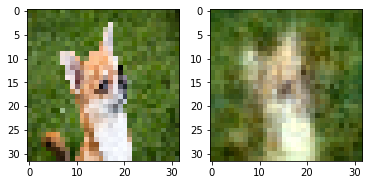

In [8]:
def vector_to_image(x):
    return x.reshape(size[0], size[1], -1)/255

plt.subplot(1,2,1)
plt.imshow(vector_to_image(X[0]))
plt.subplot(1,2,2)
plt.imshow(vector_to_image(x[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


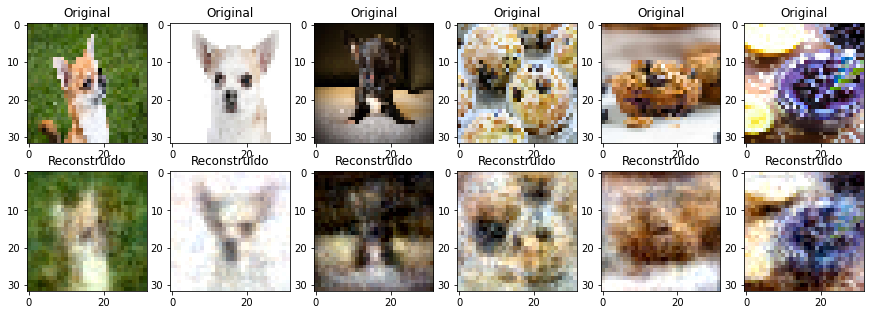

In [9]:
num_samples = 3

chihuahuas = X[Y == "chihuahua"][:num_samples]
muffins = X[Y == "muffin"][:num_samples]

samples = np.vstack((chihuahuas, muffins))
plt.figure(figsize=(15,5))
for n in range(num_samples*2):
    sample = samples[n]
    reconstruct = ppca.reconstruct(ppca.project(sample))
    
    plt.subplot(2, num_samples*2, n+1)
    plt.title("Original")
    plt.imshow(vector_to_image(sample))
    
    plt.subplot(2, num_samples*2, n+num_samples*2+1)
    plt.title("Reconstruído")
    plt.imshow(vector_to_image(reconstruct))
    
plt.show()

In [10]:
class LogisticRegression():
    
    def __init__(self):
        pass
    
    def logistic_function(self,a):
        return 1/(1+np.exp(-1*a))

    def R(self,x,w):
        prediction = self.logistic_function(x.dot(w))
        return np.diag(np.multiply(prediction, (1-prediction)).ravel())

    def A(self,x,w,S_inv):
        r = self.R(x,w)
        return x.T.dot(r).dot(x) + S_inv

    def IRLS_map(self,x,y, m, S, tol=1e-3, maxiter=100):
        w = np.zeros(x.shape[1]).reshape(-1,1)
        previous_w = None
        i = 0
        S_inv = np.linalg.inv(S)
        m = m.reshape(-1,1)
        y = y.reshape(-1,1)

        while i < maxiter and (previous_w is None or not all(np.isclose(w,previous_w, rtol=tol))):
            previous_w = np.copy(w)
            a = self.A(x,w,S_inv)
            prediction = self.logistic_function(x.dot(w))

            aux = x.T.dot(y-prediction) - S_inv.dot(w - m)

            w = w + np.linalg.inv(a).dot(aux)
            i += 1

        return w.ravel()

    def fit(self,x,y, m=None, S=None):
        m = m if not m is None else np.zeros(x.shape[1])
        S = S if S is not None else np.eye(m.shape[0])
        
        w_hat = self.IRLS_map(x,y,m,S)
        S_inv = np.linalg.inv(S)
        r_hat = self.R(x,w_hat)
        H = x.T.dot(r_hat).dot(x) + S_inv
        
        self.w_hat = w_hat
        self.var = np.linalg.inv(H)
        
    def predict_probit(self,x):
        m_a = x.dot(self.w_hat)
        sigma_a = x.dot(self.var).dot(x.T)
        print(sigma_a.shape)

        y = self.logistic_function(np.sqrt(1 + np.pi*sigma_a/8).dot(m_a))

        return np.round(np.nan_to_num(y, 0))

In [11]:
from sklearn.model_selection import train_test_split

Y_numeric = np.zeros(len(Y), dtype=int)
Y_numeric[Y == "chihuahua"] = 1

X_train, X_test, Y_train, Y_test = train_test_split(z,Y_numeric, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, Y_train)

(166, 166)


<ipython-input-10-fc4c9dbdf7dd>:54: RuntimeWarning: invalid value encountered in sqrt
  y = self.logistic_function(np.sqrt(1 + np.pi*sigma_a/8).dot(m_a))


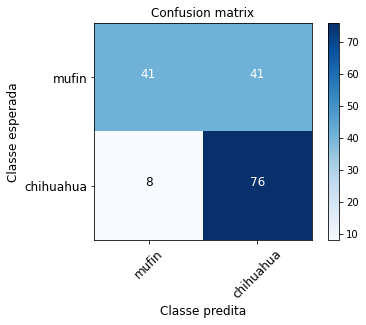

In [12]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize: # a normalização é usada para saber a porcentagem de acerto por classe
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
        nan_indexes = np.isnan(cm)
        cm[nan_indexes] = 0

    plt.figure()
    plt.rcParams["axes.grid"] = False
    plt.imshow(cm, cmap=cmap)

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                fontsize=12)

    plt.ylabel('Classe esperada', fontsize=12)
    plt.xlabel('Classe predita', fontsize=12)
    

cm = confusion_matrix(Y_test, model.predict_probit(X_test))
plot_confusion_matrix(cm, ["mufin","chihuahua"], normalize=False)

In [13]:
print("Acurácia: ",cm.diagonal().sum()/cm.sum())

Acurácia:  0.7048192771084337
